# Problemas

Nesta prática iremos usar tudo que aprendemos durante o módulo.
Logo, **seu objetivo é determinar e implementar um modelo para cada problema.**

Lembre-se de definir:

1. uma arquitetura (tentem usar tanto arquiteturas existentes como propor novas usando camadas de convolução, pooling, e densas), 
1. uma função de custo, e
1. um algoritmo de otimização (agora, como os problemas são maiores, será possível notar mais claramente a diferença entre diferentes algoritmos).





Antes de começar, vamos instalar o Pytorch. Esse pequeno bloco de código abaixo é usado somente para instalar o Pytorch para CUDA 10. Execute esse bloco somente uma vez e ignore possíveis erros levantados durante a instalação.

**ATENÇÃO: a alteração deste bloco pode implicar em problemas na execução dos blocos restantes!**

In [ ]:
!pip3 install torch torchvision

In [ ]:
import time, os, sys, numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import PIL
from PIL import Image
from torch import optim
from torchsummary import summary

# Test if GPU is avaliable, if not, use cpu instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = torch.cuda.device_count()
devices_ids= list(range(n))

In [ ]:
# funções básicas

# Função usada para calcular acurácia
def evaluate_accuracy(data_iter, net, loss):
    """Evaluate accuracy of a model on the given data set."""

    acc_sum, n, l = torch.Tensor([0]), 0, 0
    net.eval()
    with torch.no_grad():
      for X, y in data_iter:
          #y = y.astype('float32')
          X, y = X.to(device), y.to(device)
          y_hat = net(X)
          l += loss(y_hat, y).sum()
          acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
          n += y.size()[0]

    return acc_sum.item() / n, l.item() / len(data_iter)
  
# Função usada no treinamento e validação da rede
def train_validate(net, train_iter, test_iter, batch_size, trainer, loss,
                   num_epochs):
    print('training on', device)
    for epoch in range(num_epochs):
        net.train()
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            trainer.zero_grad()
            l = loss(y_hat, y).sum()
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.size()[0]
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss)
        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, '
              'test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / len(train_iter), train_acc_sum / n, test_loss, 
                 test_acc, time.time() - start))


## Problema 1

Neste problema, classificaremos imagens histólogica do dataset [*Colorectal Histology*](https://www.kaggle.com/kmader/colorectal-histology-mnist).
Neste caso, vamos receber imagens com tamanho de $150\times 150$ pixels e classificá-las entre 8 classes: 

1. tumor
1. stroma
1. complex
1. lympho
1. debris
1. mucosa
1. adipose
1. empty

In [ ]:
# Baixando o dataset
!wget https://www.dropbox.com/s/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip
!unzip -q Kather_texture_2016_image_tiles_5000.zip

In [ ]:
class HistologyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=True, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.le = {'tumor': 0, 'stroma': 1, 'complex': 2, 'lympho': 3, 'debris': 4, 'mucosa': 5, 'adipose': 6, 'empty': 7}
        self.transform = transform
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
          for folder in os.listdir(self.root):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num < 500:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(self.le[folder.split('_')[1].lower()])
        else:
          for folder in os.listdir(os.path.join(self.root)):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num >= 500:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(self.le[folder.split('_')[1].lower()])
 
        return img_list, labels

    def __getitem__(self, item):
        # retorna uma imagem para o treino/teste
        if self.has_norm is True:
            # normaliza a imagem se has_norm for setado como True
            cur_img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            # apenas converte a imagem para tensor, sem normalizar
            cur_img = self.transform(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        # normaliza uma imagem
        # se calc_norm for True, normaliza pela subtração da média dividida pelo desvio para cada canal da imagem
        # se calc_norm for False, normaliza pelos valores pré-definidos de média e desvio padrão
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # neste caso, a sequência é um redimensionamento da imagem (caso a variável resize seja definida)
    # seguido de uma transformação para tensor
    # várias outras transformações estão disponíveis no Pytorch, como crops, flips, espelhamento e etc.
    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize,resize))]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, transform=transformer, train=True) #obtem dataset de treino
    test = dataset(root=root, transform=transformer, train=False) #obtem dataset de validação
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers) # criação do dataloader de treino
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers) # criação do dataloader de teste
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 64
train_iter, test_iter = load_data(HistologyDataset, 'Kather_texture_2016_image_tiles_5000', batch_size, resize=None)

In [ ]:
# definição da minha rede (uma versão da AlexNet)
class MyAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(MyAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

NUM_CLASSES = 8
num_epochs = 20
lr = 0.001

# cria a rede
model = MyAlexNet(NUM_CLASSES).to(device)

# definição da loss
loss = nn.CrossEntropyLoss().to(device)

# definição do otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# treinamento e validação
train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

training on cuda
epoch 1, train loss 2.2342, train acc 0.177, test loss 2.3644, test acc 0.149, time 7.1 sec
epoch 2, train loss 1.6353, train acc 0.278, test loss 1.5635, test acc 0.391, time 7.2 sec
epoch 3, train loss 1.3426, train acc 0.466, test loss 1.2839, test acc 0.514, time 7.2 sec
epoch 4, train loss 1.1433, train acc 0.540, test loss 1.1056, test acc 0.544, time 7.0 sec
epoch 5, train loss 1.0030, train acc 0.594, test loss 1.1177, test acc 0.593, time 7.1 sec
epoch 6, train loss 0.8995, train acc 0.649, test loss 0.9591, test acc 0.651, time 7.1 sec
epoch 7, train loss 0.8260, train acc 0.688, test loss 1.0600, test acc 0.611, time 7.3 sec
epoch 8, train loss 0.8522, train acc 0.674, test loss 0.8085, test acc 0.733, time 7.2 sec
epoch 9, train loss 0.7664, train acc 0.712, test loss 0.9274, test acc 0.671, time 7.1 sec
epoch 10, train loss 0.7123, train acc 0.734, test loss 0.7806, test acc 0.726, time 7.2 sec
epoch 11, train loss 0.6652, train acc 0.747, test loss 0.7729

## Problema 2

Neste problema, classificaremos imagens de sensoriamento remoto de plantações de café do dataset público [Brazilian Coffee Scenes](http://www.patreo.dcc.ufmg.br/2017/11/12/brazilian-coffee-scenes-dataset/).
Neste caso, , vamos receber imagens de $64\times 64$ pixels e classificá-las entre duas classes: 

1. café, e 
2. não café.

In [ ]:
# Baixando o dataset
!wget http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip
!unzip -q brazilian_coffee_dataset.zip

--2021-02-09 19:53:48--  http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip
Resolving www.patreo.dcc.ufmg.br (www.patreo.dcc.ufmg.br)... 150.164.11.226
Connecting to www.patreo.dcc.ufmg.br (www.patreo.dcc.ufmg.br)|150.164.11.226|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4796290 (4.6M) [application/zip]
Saving to: ‘brazilian_coffee_dataset.zip’

brazilian_coffee_da 100%[===================>]   4.57M  2.98MB/s    in 1.5s    

2021-02-09 19:53:51 (2.98 MB/s) - ‘brazilian_coffee_dataset.zip’ saved [4796290/4796290]



In [ ]:
class CoffeeDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=True, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.load_images()
        self.transform = transform

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)
        
    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
          for i in range(1,5):
            data_file = open(os.path.join(root, 'fold' + str(i+1) + '.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for row in data_list:
                img_name = '.'.join(row.split('.')[1:])
                img_list.append(os.path.join(root, 'fold' + str(i+1), img_name + '.jpg'))
                labels.append(0 if row.split('.')[0] == 'coffee' else 1)
        else:
            data_file = open(os.path.join(root, 'fold1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for row in data_list:
                img_name = '.'.join(row.split('.')[1:])
                img_list.append(os.path.join(root, 'fold1', img_name + '.jpg'))
                labels.append(0 if row.split('.')[0] == 'coffee' else 1)
 
        return img_list, labels

    def __getitem__(self, item):
        # retorna uma imagem para o treino/teste
        if self.has_norm is True:
            # normaliza a imagem se has_norm for setado como True
            cur_img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            # apenas converte a imagem para tensor, sem normalizar
            cur_img = self.transform(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        # normaliza uma imagem
        # se calc_norm for True, normaliza pela subtração da média dividida pelo desvio para cada canal da imagem
        # se calc_norm for False, normaliza pelos valores pré-definidos de média e desvio padrão
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # neste caso, a sequência é um redimensionamento da imagem (caso a variável resize seja definida)
    # seguido de uma transformação para tensor
    # várias outras transformações estão disponíveis no Pytorch, como crops, flips, espelhamento e etc.
    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize,resize))]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, transform=transformer, train=True) #obtem dataset de treino
    test = dataset(root=root, transform=transformer, train=False) #obtem dataset de validação
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers) # criação do dataloader de treino
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers) # criação do dataloader de teste
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 64
train_iter, test_iter = load_data(CoffeeDataset, 'brazilian_coffee_scenes', batch_size, resize=None)

In [ ]:
# IMPLEMENTE AQUI SUA SOLUÇÃO
    
# definindo minha CNN (uma versão da AlexNet)
class MyAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(MyAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

NUM_CLASSES = 2
num_epochs = 20
lr = 0.001

# cria a rede
model = MyAlexNet(NUM_CLASSES).to(device)

# definição da loss
loss = nn.CrossEntropyLoss().to(device)

# definição do otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# treinamento e validação
train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

training on cuda
epoch 1, train loss 0.7630, train acc 0.513, test loss 0.6600, test acc 0.500, time 8.0 sec
epoch 2, train loss 0.7042, train acc 0.516, test loss 0.6862, test acc 0.500, time 8.1 sec
epoch 3, train loss 0.6963, train acc 0.551, test loss 0.6948, test acc 0.500, time 8.2 sec
epoch 4, train loss 0.6761, train acc 0.566, test loss 0.6287, test acc 0.587, time 8.0 sec
epoch 5, train loss 0.6345, train acc 0.638, test loss 0.6772, test acc 0.500, time 8.0 sec
epoch 6, train loss 0.6026, train acc 0.678, test loss 0.4870, test acc 0.785, time 8.0 sec
epoch 7, train loss 0.5220, train acc 0.749, test loss 0.4905, test acc 0.767, time 8.0 sec
epoch 8, train loss 0.4974, train acc 0.778, test loss 0.3893, test acc 0.820, time 8.0 sec
epoch 9, train loss 0.4306, train acc 0.814, test loss 0.4290, test acc 0.803, time 8.1 sec
epoch 10, train loss 0.4452, train acc 0.804, test loss 0.4878, test acc 0.775, time 8.1 sec
epoch 11, train loss 0.4128, train acc 0.820, test loss 0.3381

## Problema 3

Neste problema, classificaremos imagens gerais de sensoriamento remoto do dataset público [UCMerced](http://weegee.vision.ucmerced.edu/datasets/landuse.html).
Neste caso, vamos receber imagens de $256\times 256$ pixels e classificá-las entre 21 classes: 

1. agricultural
1. airplane
1. baseballdiamond
1. beach
1. buildings
1. chaparral
1. denseresidential
1. forest
1. freeway
1. golfcourse
1. harbor
1. intersection
1. mediumresidential
1. mobilehomepark
1. overpass
1. parkinglot
1. river
1. runway
1. sparseresidential
1. storagetanks
1. tenniscourt

In [ ]:
# Baixando o dataset
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -q UCMerced_LandUse.zip

--2021-02-09 02:36:28--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  35.7MB/s    in 13s     

2021-02-09 02:36:42 (24.8 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



In [ ]:
class UCMercedDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=False, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.transform = transform
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)
        
    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
          for cat, folder in enumerate(os.listdir(self.root)):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num < 80:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(cat)
        else:
          for cat, folder in enumerate(os.listdir(os.path.join(self.root))):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num >= 80:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(cat)
 
        return img_list, labels

    def __getitem__(self, item):
        # retorna uma imagem para o treino/teste
        if self.has_norm is True:
            # normaliza a imagem se has_norm for setado como True
            cur_img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            # apenas converte a imagem para tensor, sem normalizar
            cur_img = self.transform(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        # normaliza uma imagem
        # se calc_norm for True, normaliza pela subtração da média dividida pelo desvio para cada canal da imagem
        # se calc_norm for False, normaliza pelos valores pré-definidos de média e desvio padrão
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # neste caso, a sequência é um redimensionamento da imagem (caso a variável resize seja definida)
    # seguido de uma transformação para tensor
    # várias outras transformações estão disponíveis no Pytorch, como crops, flips, espelhamento e etc.
    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize,resize))]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, transform=transformer, train=True) #obtem dataset de treino
    test = dataset(root=root, transform=transformer, train=False) #obtem dataset de validação
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers) # criação do dataloader de treino
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers) # criação do dataloader de teste
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 64
train_iter, test_iter = load_data(UCMercedDataset, os.path.join('UCMerced_LandUse', 'Images'), batch_size, resize=256)

In [ ]:
# IMPLEMENTE AQUI SUA SOLUÇÃO

NUM_CLASSES = 21
num_epochs = 20
lr = 0.001

# utilizando a alexnet já pré-treinada definida no torchvision (outras redes são possíveis também)
model = torchvision.models.alexnet(pretrained=True)
# alterando o output da última camada de classificação para o número de classes do nosso problema
model.classifier[6] = nn.Linear(4096,NUM_CLASSES)
model = model.to(device)

# definição da loss
loss = nn.CrossEntropyLoss().to(device)

# definição do otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# treinamento e validação
train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

training on cuda
epoch 1, train loss 2.3755, train acc 0.324, test loss 1.8151, test acc 0.471, time 6.2 sec
epoch 2, train loss 1.4276, train acc 0.578, test loss 1.2135, test acc 0.590, time 6.2 sec
epoch 3, train loss 1.1881, train acc 0.645, test loss 1.2819, test acc 0.631, time 6.3 sec
epoch 4, train loss 0.9119, train acc 0.710, test loss 1.0946, test acc 0.657, time 6.0 sec
epoch 5, train loss 0.7691, train acc 0.760, test loss 1.0748, test acc 0.702, time 6.3 sec
epoch 6, train loss 0.6568, train acc 0.796, test loss 1.8070, test acc 0.633, time 6.5 sec
epoch 7, train loss 0.6512, train acc 0.801, test loss 1.1169, test acc 0.764, time 6.3 sec
epoch 8, train loss 0.5134, train acc 0.824, test loss 0.7241, test acc 0.786, time 6.5 sec
epoch 9, train loss 0.4313, train acc 0.863, test loss 0.8047, test acc 0.762, time 6.3 sec
epoch 10, train loss 0.3420, train acc 0.893, test loss 0.8440, test acc 0.764, time 6.3 sec
epoch 11, train loss 0.4127, train acc 0.878, test loss 0.7297

## Problema 4

Neste problema, classificaremos imagens genéricas de textura do dataset público [*Describable Textures Dataset*](http://www.robots.ox.ac.uk/~vgg/data/dtd/).
Neste caso, vamos receber imagens com tamanho variado (de $300\times 300$ pixels até $640\times 640$) e classificá-las entre 47 classes: 

1.  banded
1.  blotchy
1.  braided
1.  bubbly
1.  bumpy
1.  chequered
1.  cobwebbed
1.  cracked
1.  crosshatched
1.  crystalline
1.  dotted
1.  fibrous
1.  flecked
1.  freckled
1.  frilly
1.  gauzy
1.  grid
1.  grooved
1.  honeycombed
1.  interlaced
1.  knitted
1.  lacelike
1.  lined
1.  marbled
1.  matted
1.  meshed
1.  paisley
1.  perforated
1.  pitted
1.  pleated
1.  polka-dotted
1.  porous
1.  potholed
1.  scaly
1.  smeared
1.  spiralled
1.  sprinkled
1.  stained
1.  stratified
1.  striped
1.  studded
1.  swirly
1.  veined
1.  waffled
1.  woven
1.  wrinkled
1.  zigzagged

In [ ]:
# Download do dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
!tar -xzf dtd-r1.0.1.tar.gz

--2021-02-09 13:12:00--  http://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz [following]
--2021-02-09 13:12:00--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/x-gzip]
Saving to: ‘dtd-r1.0.1.tar.gz’

dtd-r1.0.1.tar.gz   100%[===================>] 596.27M  65.6MB/s    in 9.1s    

2021-02-09 13:12:09 (65.7 MB/s) - ‘dtd-r1.0.1.tar.gz’ saved [625239812/625239812]



In [ ]:
class TextureDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=False, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.le = {'banded': 0, 'blotchy': 1, 'braided': 2, 'bubbly': 3, 'bumpy': 4, 'chequered': 5, 'cobwebbed': 6, 'cracked': 7, 'crosshatched': 8, 'crystalline': 9, 'dotted': 10, 'fibrous': 11, 'flecked': 12, 'freckled': 13, 'frilly': 14, 'gauzy': 15, 'grid': 16, 'grooved': 17, 'honeycombed': 18, 'interlaced': 19, 'knitted': 20, 'lacelike': 21, 'lined': 22, 'marbled': 23, 'matted': 24, 'meshed': 25, 'paisley': 26, 'perforated': 27, 'pitted': 28, 'pleated': 29, 'polka-dotted': 30, 'porous': 31, 'potholed': 32, 'scaly': 33, 'smeared': 34, 'spiralled': 35, 'sprinkled': 36, 'stained': 37, 'stratified': 38, 'striped': 39, 'studded': 40, 'swirly': 41, 'veined': 42, 'waffled': 43, 'woven': 44, 'wrinkled': 45, 'zigzagged': 46}
        self.transform = transform
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        img_list, labels = [], []
        if self.train is True:
            data_file = open(os.path.join(root, 'labels', 'train1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for img_path in data_list:
                img_list.append(os.path.join(root, 'images', img_path))
                labels.append(self.le[img_path.split('/')[0]])
                
            data_file = open(os.path.join(root, 'labels', 'val1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for img_path in data_list:
                img_list.append(os.path.join(root, 'images', img_path))
                labels.append(self.le[img_path.split('/')[0]])
        else:
            data_file = open(os.path.join(root, 'labels', 'test1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for img_path in data_list:
                img_list.append(os.path.join(root, 'images', img_path))
                labels.append(self.le[img_path.split('/')[0]])

        return img_list, labels

    def __getitem__(self, item):
        # retorna uma imagem para o treino/teste
        if self.has_norm is True:
            # normaliza a imagem se has_norm for setado como True
            cur_img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            # apenas converte a imagem para tensor, sem normalizar
            cur_img = self.transform(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label
        
    def __len__(self):
        return len(self.img_list)
      
    def normalize_image(self, img):
        # normaliza uma imagem
        # se calc_norm for True, normaliza pela subtração da média dividida pelo desvio para cada canal da imagem
        # se calc_norm for False, normaliza pelos valores pré-definidos de média e desvio padrão
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img
      
      
def load_data(dataset, root, batch_size, resize=None):
    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # neste caso, a sequência é um redimensionamento da imagem (caso a variável resize seja definida)
    # seguido de uma transformação para tensor
    # várias outras transformações estão disponíveis no Pytorch, como crops, flips, espelhamento e etc.
    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize,resize))]
    else:
        transformer += [torchvision.transforms.RandomCrop(224, padding=4)]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, transform=transformer, train=True) #obtem dataset de treino
    test = dataset(root=root, transform=transformer, train=False) #obtem dataset de validação
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers) # criação do dataloader de treino
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers) # criação do dataloader de teste
    return train_iter, test_iter
  
# carregamento do dado
batch_size = 32
train_iter, test_iter = load_data(TextureDataset, os.path.join('dtd'), batch_size, resize=None)

In [ ]:
# IMPLEMENTE AQUI SUA SOLUÇÃO
    
NUM_CLASSES = 47
num_epochs = 20
lr = 0.001

# utilizando a alexnet já pré-treinada definida no torchvision (outras redes são possíveis também)
model = torchvision.models.resnet34(pretrained=True)
# alterando o output da última camada de classificação para o número de classes do nosso problema
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,NUM_CLASSES)
model = model.to(device)

# definição da loss
loss = nn.CrossEntropyLoss().to(device)

# definição do otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# treinamento e validação
train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

training on cuda
epoch 1, train loss 3.5278, train acc 0.122, test loss 3.4701, test acc 0.142, time 58.9 sec
epoch 2, train loss 2.8496, train acc 0.240, test loss 2.8275, test acc 0.275, time 59.4 sec
epoch 3, train loss 2.4601, train acc 0.323, test loss 2.3942, test acc 0.338, time 59.1 sec
epoch 4, train loss 2.2008, train acc 0.378, test loss 2.2794, test acc 0.370, time 59.5 sec
epoch 5, train loss 2.0518, train acc 0.411, test loss 2.2473, test acc 0.396, time 59.2 sec
epoch 6, train loss 1.8916, train acc 0.448, test loss 2.2200, test acc 0.416, time 59.7 sec
epoch 7, train loss 1.7386, train acc 0.495, test loss 2.0308, test acc 0.439, time 59.2 sec
epoch 8, train loss 1.6430, train acc 0.508, test loss 2.1213, test acc 0.421, time 59.5 sec
epoch 9, train loss 1.5452, train acc 0.545, test loss 2.0270, test acc 0.448, time 59.2 sec
epoch 10, train loss 1.4169, train acc 0.569, test loss 1.9855, test acc 0.478, time 59.6 sec
epoch 11, train loss 1.3880, train acc 0.583, test l

In [ ]:
# função auxiliar para plotar imagens do dataset

from matplotlib import pyplot as plt

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    axes = plt.subplots(num_rows, num_cols, figsize=figsize)[1].flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb90f7ae48>,
      dtype=object)

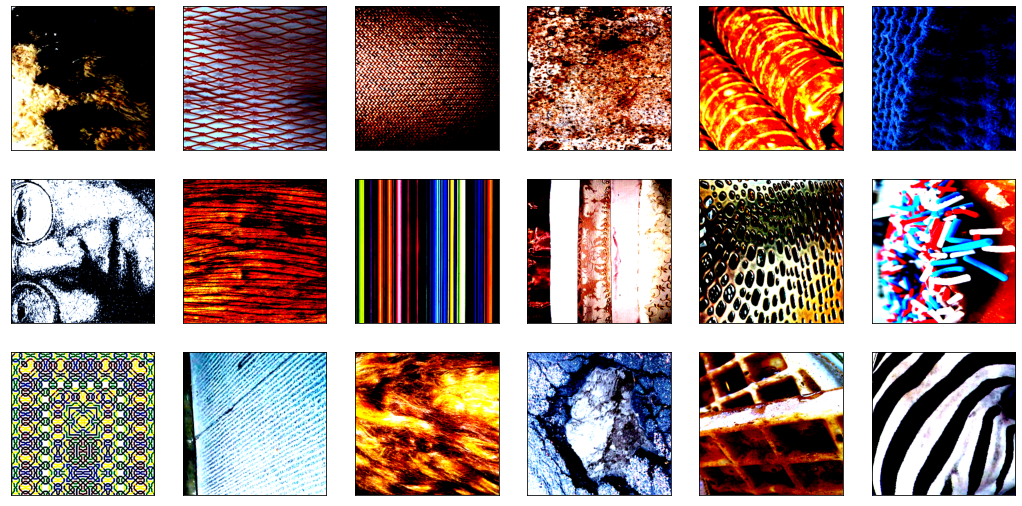

In [ ]:
#plota imagens do dataset

imgs = []
for X, y in train_iter:
    X = np.swapaxes(X, 1, 3)
    imgs = X[0:18]
    break
    
    
show_images(imgs, 3, 6, titles=None, scale=3)